In [1]:
import pandas as pd
import numpy as np
import math
import ipywidgets as widgets

##Seaborn for fancy plots. 
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns


import geopandas as gpd
from shapely.geometry import Point
#import fiona

plt.rcParams['figure.figsize'] = (20, 9)
plt.style.use('Solarize_Light2')

import folium # mapping
from folium.plugins import HeatMap

In [2]:
df=pd.read_csv('neighborhooddata-crimedata-weatherdata.csv', encoding_errors='ignore')
df.rename(columns={'Neighbourhood Name': 'NGH_Name', 'Neighbourhood Number':'NGH_Number'}, inplace=True)
#df.drop(['Month-Year.1', 'Month-Year'], axis=1, inplace =True)
df.drop(['Descriptive Name'], axis=1, inplace =True)
df.drop(['Month-Year.1'], axis=1, inplace =True)
df.drop(['Occurrence Reported Quarter'], axis=1, inplace =True)
df.rename(columns={'Occurrence Violation Type Group': 'Violation_Type', 'Occurrence Reported Month':'Reported_Month', 'Occurrence Reported Year':'Reported_Year'}, inplace=True)
df.rename(columns={'Occurrence Reported Quarter': 'QRT', 'Number of Occurrences':'Sum_Occurrences'}, inplace=True)

df['Month-Year']=pd.to_datetime(df['Month-Year'], format='%b-%y')
df['DT_Year']=df['Month-Year'].dt.year
df['DT_Month']=df['Month-Year'].dt.month_name()
df.drop(['Reported_Year'], axis=1, inplace =True)
df.drop(['Reported_Month'], axis=1, inplace =True)
df.drop(['Month-Year'], axis=1, inplace =True)

df['AVG_Temp']=(df['Air Temp. Avg. Max. (C)']+df['Air Temp. Avg. Min. (C)'])/2
df.drop(['Air Temp. Avg. Min. (C)'], axis=1, inplace =True)
df.drop(['Air Temp. Avg. Max. (C)'], axis=1, inplace =True)


df.head(2)

,NGH_Name,NGH_Number,Latitude,Longitude,Violation_Type,Sum_Occurrences,DT_Year,DT_Month,AVG_Temp
0,AMBLESIDE,5505,53.430642,-113.600677,Break and Enter,1,2015,May,10.563387
1,ANTHONY HENDAY SOUTH,4014,53.432209,-113.547667,Break and Enter,1,2015,May,10.563387


In [3]:
# Filter the data to the years 2009-2019
df_2016 = df.loc[df['DT_Year'] == 2016]

# Filter the data to only include the desired violation types
violation_types = ['Assault', 'Homicide', 'Sexual Assaults', 'Robbery']
df_2016 = df_2016.loc[df_2016['Violation_Type'].isin(violation_types)]
df_2016

,NGH_Name,NGH_Number,Latitude,Longitude,Violation_Type,Sum_Occurrences,DT_Year,DT_Month,AVG_Temp
33016,SAKAW,6670,53.441980,-113.428828,Assault,1,2016,October,2.003065
33017,SATOO,6680,53.446373,-113.458892,Assault,1,2016,October,2.003065
33018,ALBANY,3460,53.632382,-113.549464,Assault,1,2016,October,2.003065
33019,AMBLESIDE,5505,53.430642,-113.600677,Assault,1,2016,October,2.003065
33020,ANTHONY HENDAY RAMPART,4023,53.627497,-113.576375,Assault,1,2016,October,2.003065
...,...,...,...,...,...,...,...,...,...
111858,DOWNTOWN,1090,53.539767,-113.499421,Assault,34,2016,August,16.532419
111859,DOWNTOWN,1090,53.539767,-113.499421,Assault,42,2016,September,10.994667
111860,DOWNTOWN,1090,53.539767,-113.499421,Assault,39,2016,October,2.003065
111861,DOWNTOWN,1090,53.539767,-113.499421,Assault,36,2016,November,0.948667


Let us look at the Count of the Violation_Types for 2016
<li> Violations_type=[Assaule, Robbery, Sexual Assault, Homicide]

In [4]:
# What are the most common types of crimes between 2009 & 2019
count_crimes_2016=pd.DataFrame({'Count': df_2016['Violation_Type'].value_counts().sort_values(ascending=False).head(10)})
count_crimes_2016

,Count
Assault,1936
Robbery,716
Sexual Assaults,545
Homicide,24


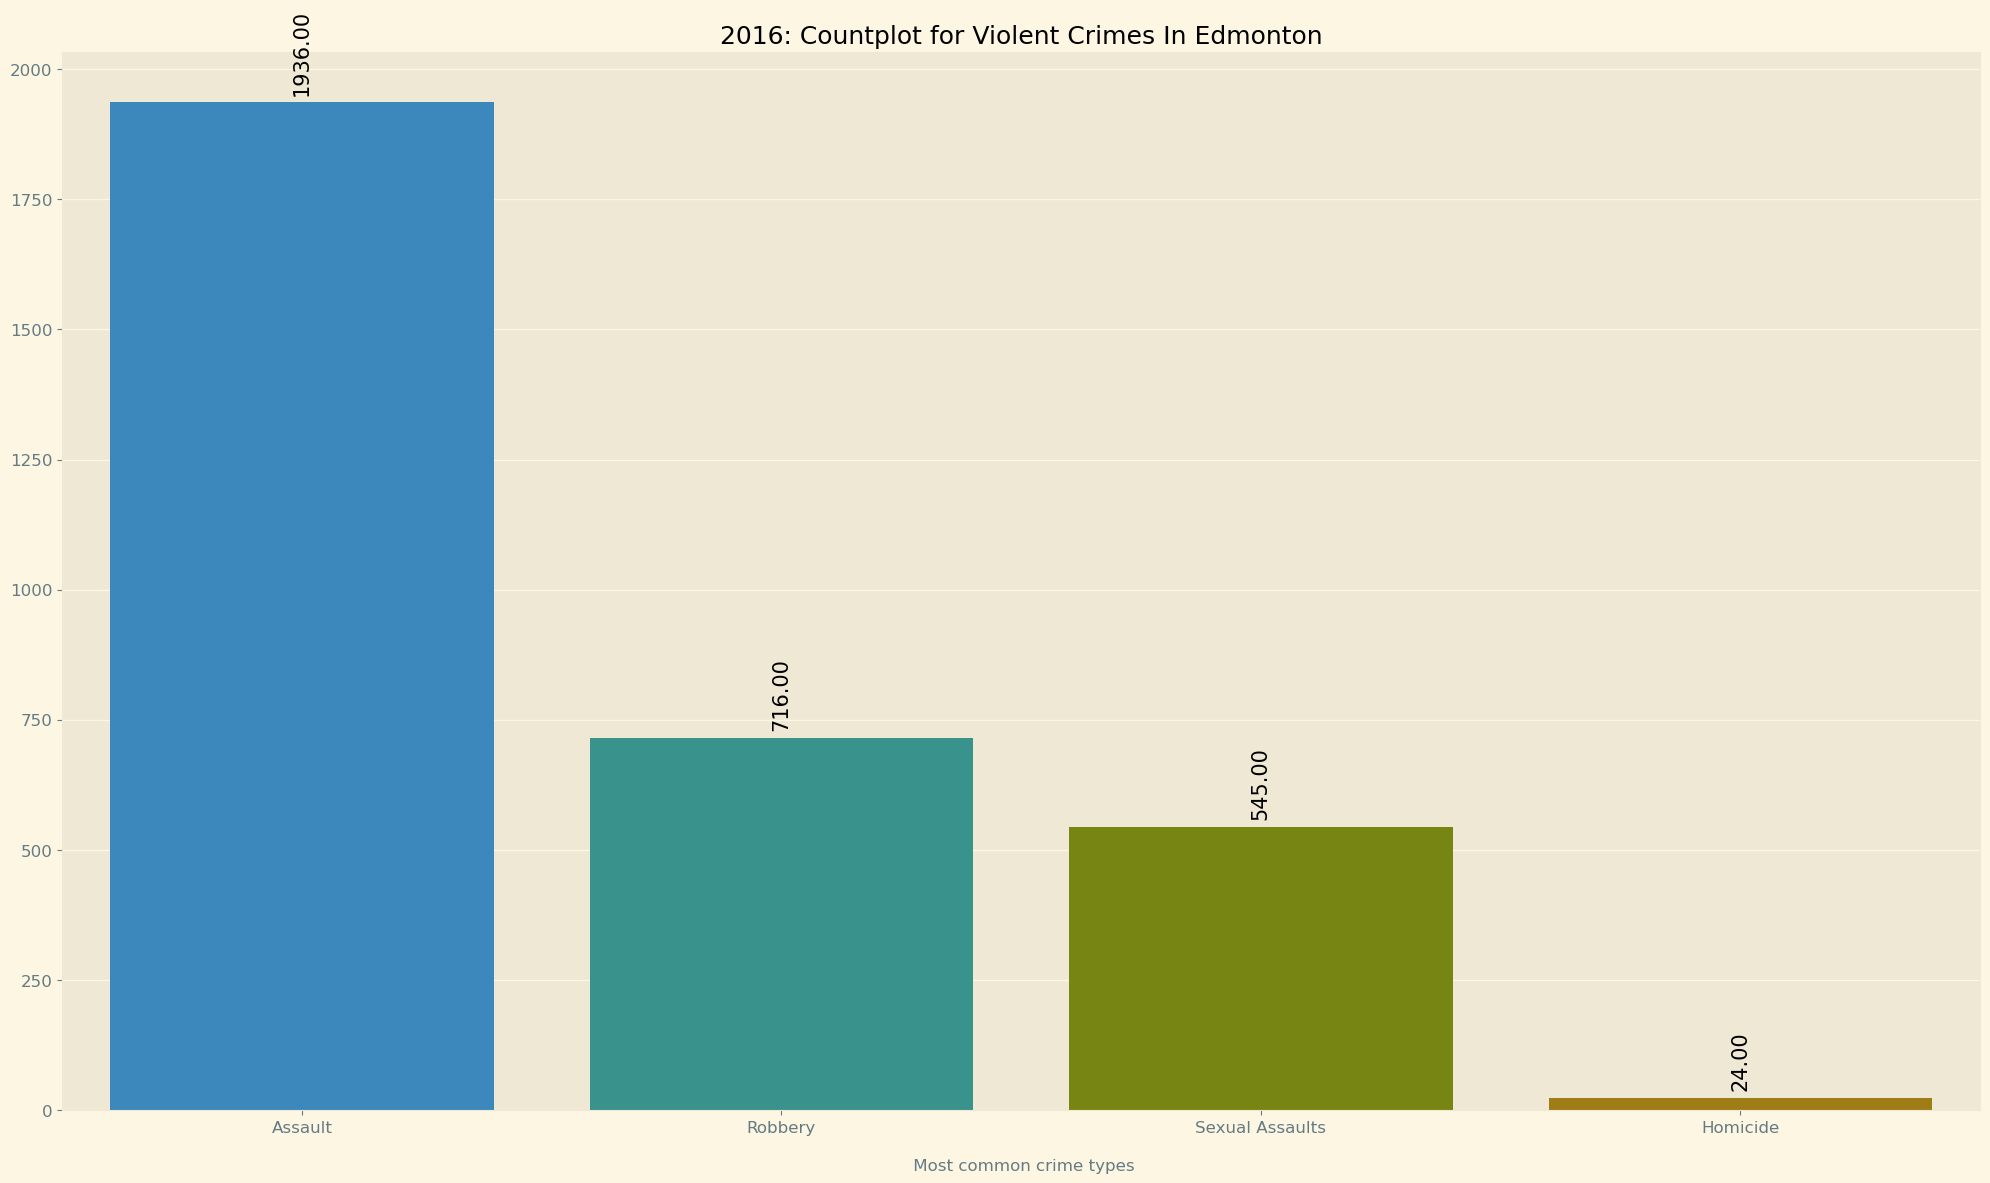

In [5]:
plt.figure(figsize = (20,12))
splot=sns.barplot(x = count_crimes_2016.index, y = 'Count', data = count_crimes_2016)
# add annotations
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()),  
                   ha='center', va='bottom', fontsize=15, color='black', rotation=90, xytext=(0, 5), 
                   textcoords='offset points')
#plt.yticks((np.arange(5000, most_common_crimes['Count'].max(), 5000)))
plt.ylabel(None)
plt.tick_params(labelsize = 12)
plt.xlabel('\n Most common crime types', fontsize = 12)
plt.title('2016: Countplot for Violent Crimes In Edmonton', fontsize = 18)
plt.tight_layout()

Top 6 Neighbourhoods with highest Count of Violations?

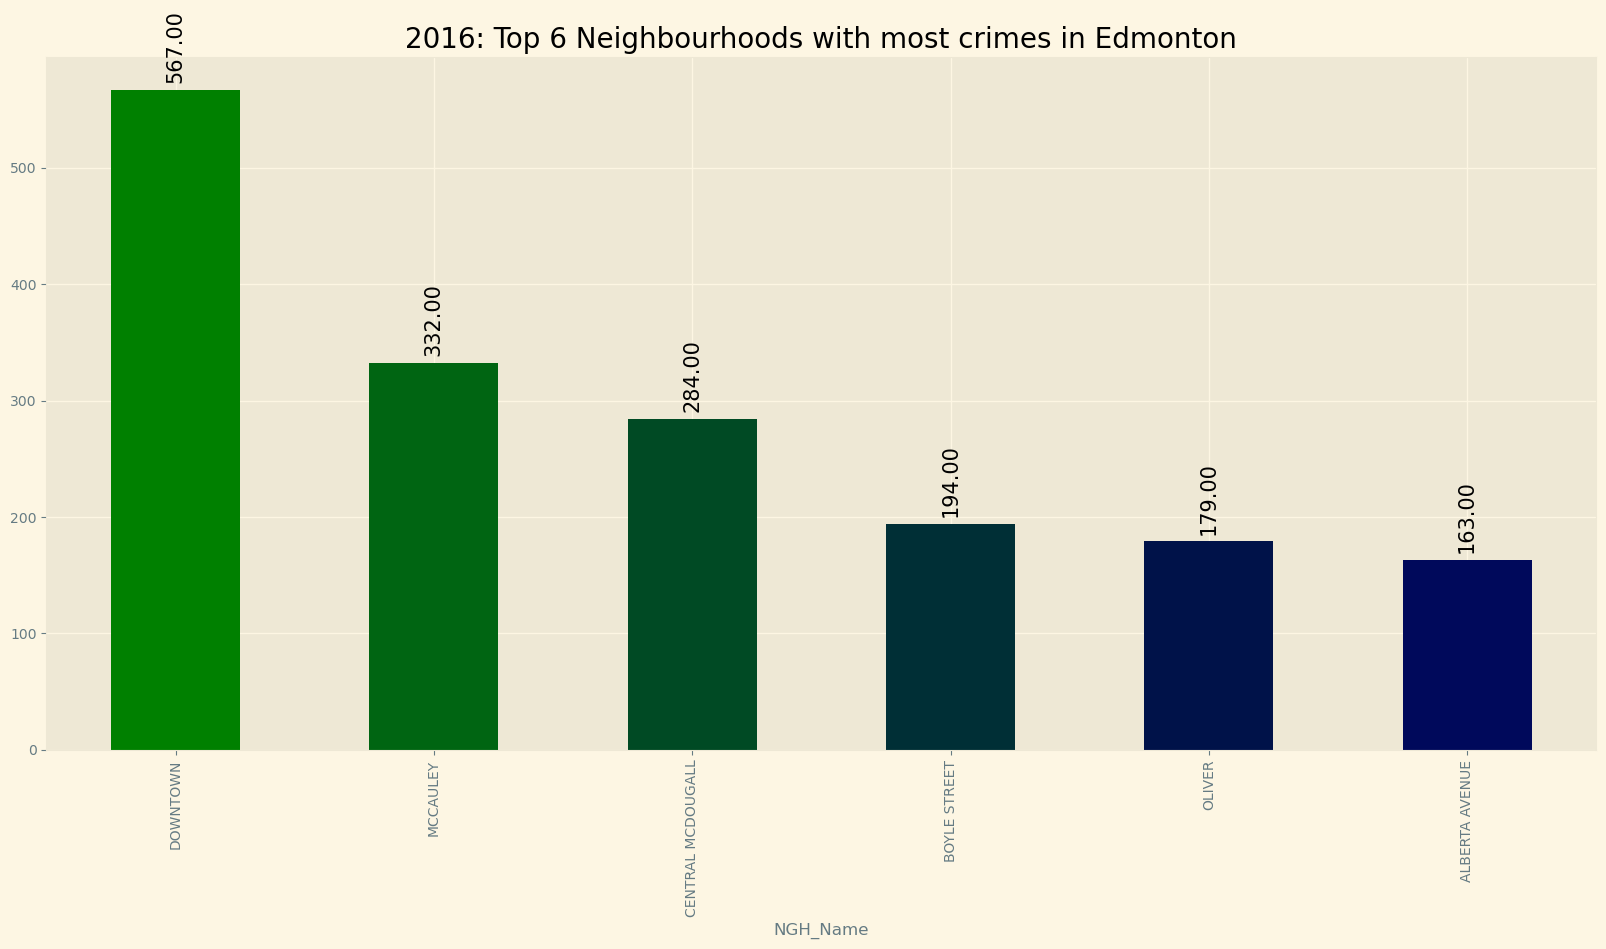

In [6]:
color = plt.cm.ocean(np.linspace(0, 1, 15))
splot=df_2016.groupby(['NGH_Name'])['Sum_Occurrences'].sum().sort_values(ascending=False).head(6).plot.bar(color=color)
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()),  
                   ha='center', va='bottom', fontsize=15, color='black', rotation=90, xytext=(0, 5), 
                   textcoords='offset points')
plt.title('2016: Top 6 Neighbourhoods with most crimes in Edmonton',fontsize = 20)
plt.xticks(rotation = 90)
plt.show()

In [17]:
# calculate total sum of occurrences across all neighborhoods
total_occurrences = df_2016['Sum_Occurrences'].sum()

# filter dataframe to only include top 6 neighborhoods
top_6_occurrences = df_2016[df_2016['NGH_Name'].isin(['DOWNTOWN', 'MCCUULEY', 'CENTRAL MCDOUGALL', 'BOYLE STREET', 'OLIVER', 'ALBERTA AVENUE'])]['Sum_Occurrences'].sum()

# calculate percentage of total crime held by top 6 neighborhoods
percentage_top_6 = (top_6_occurrences / total_occurrences) * 100

# print the result
print("The top 6 neighborhoods hold {:.2f}% of the overall crime".format(percentage_top_6))


The top 6 neighborhoods hold 18.36% of the overall crime


Again, we see that Downtown, McCauley, Central McDiugall, Boyle Street Oliver & Alberta Avenue how up with the highest count of violations.


Let us look at the breakdown by Violation_type for our 6 Neighbourhoods

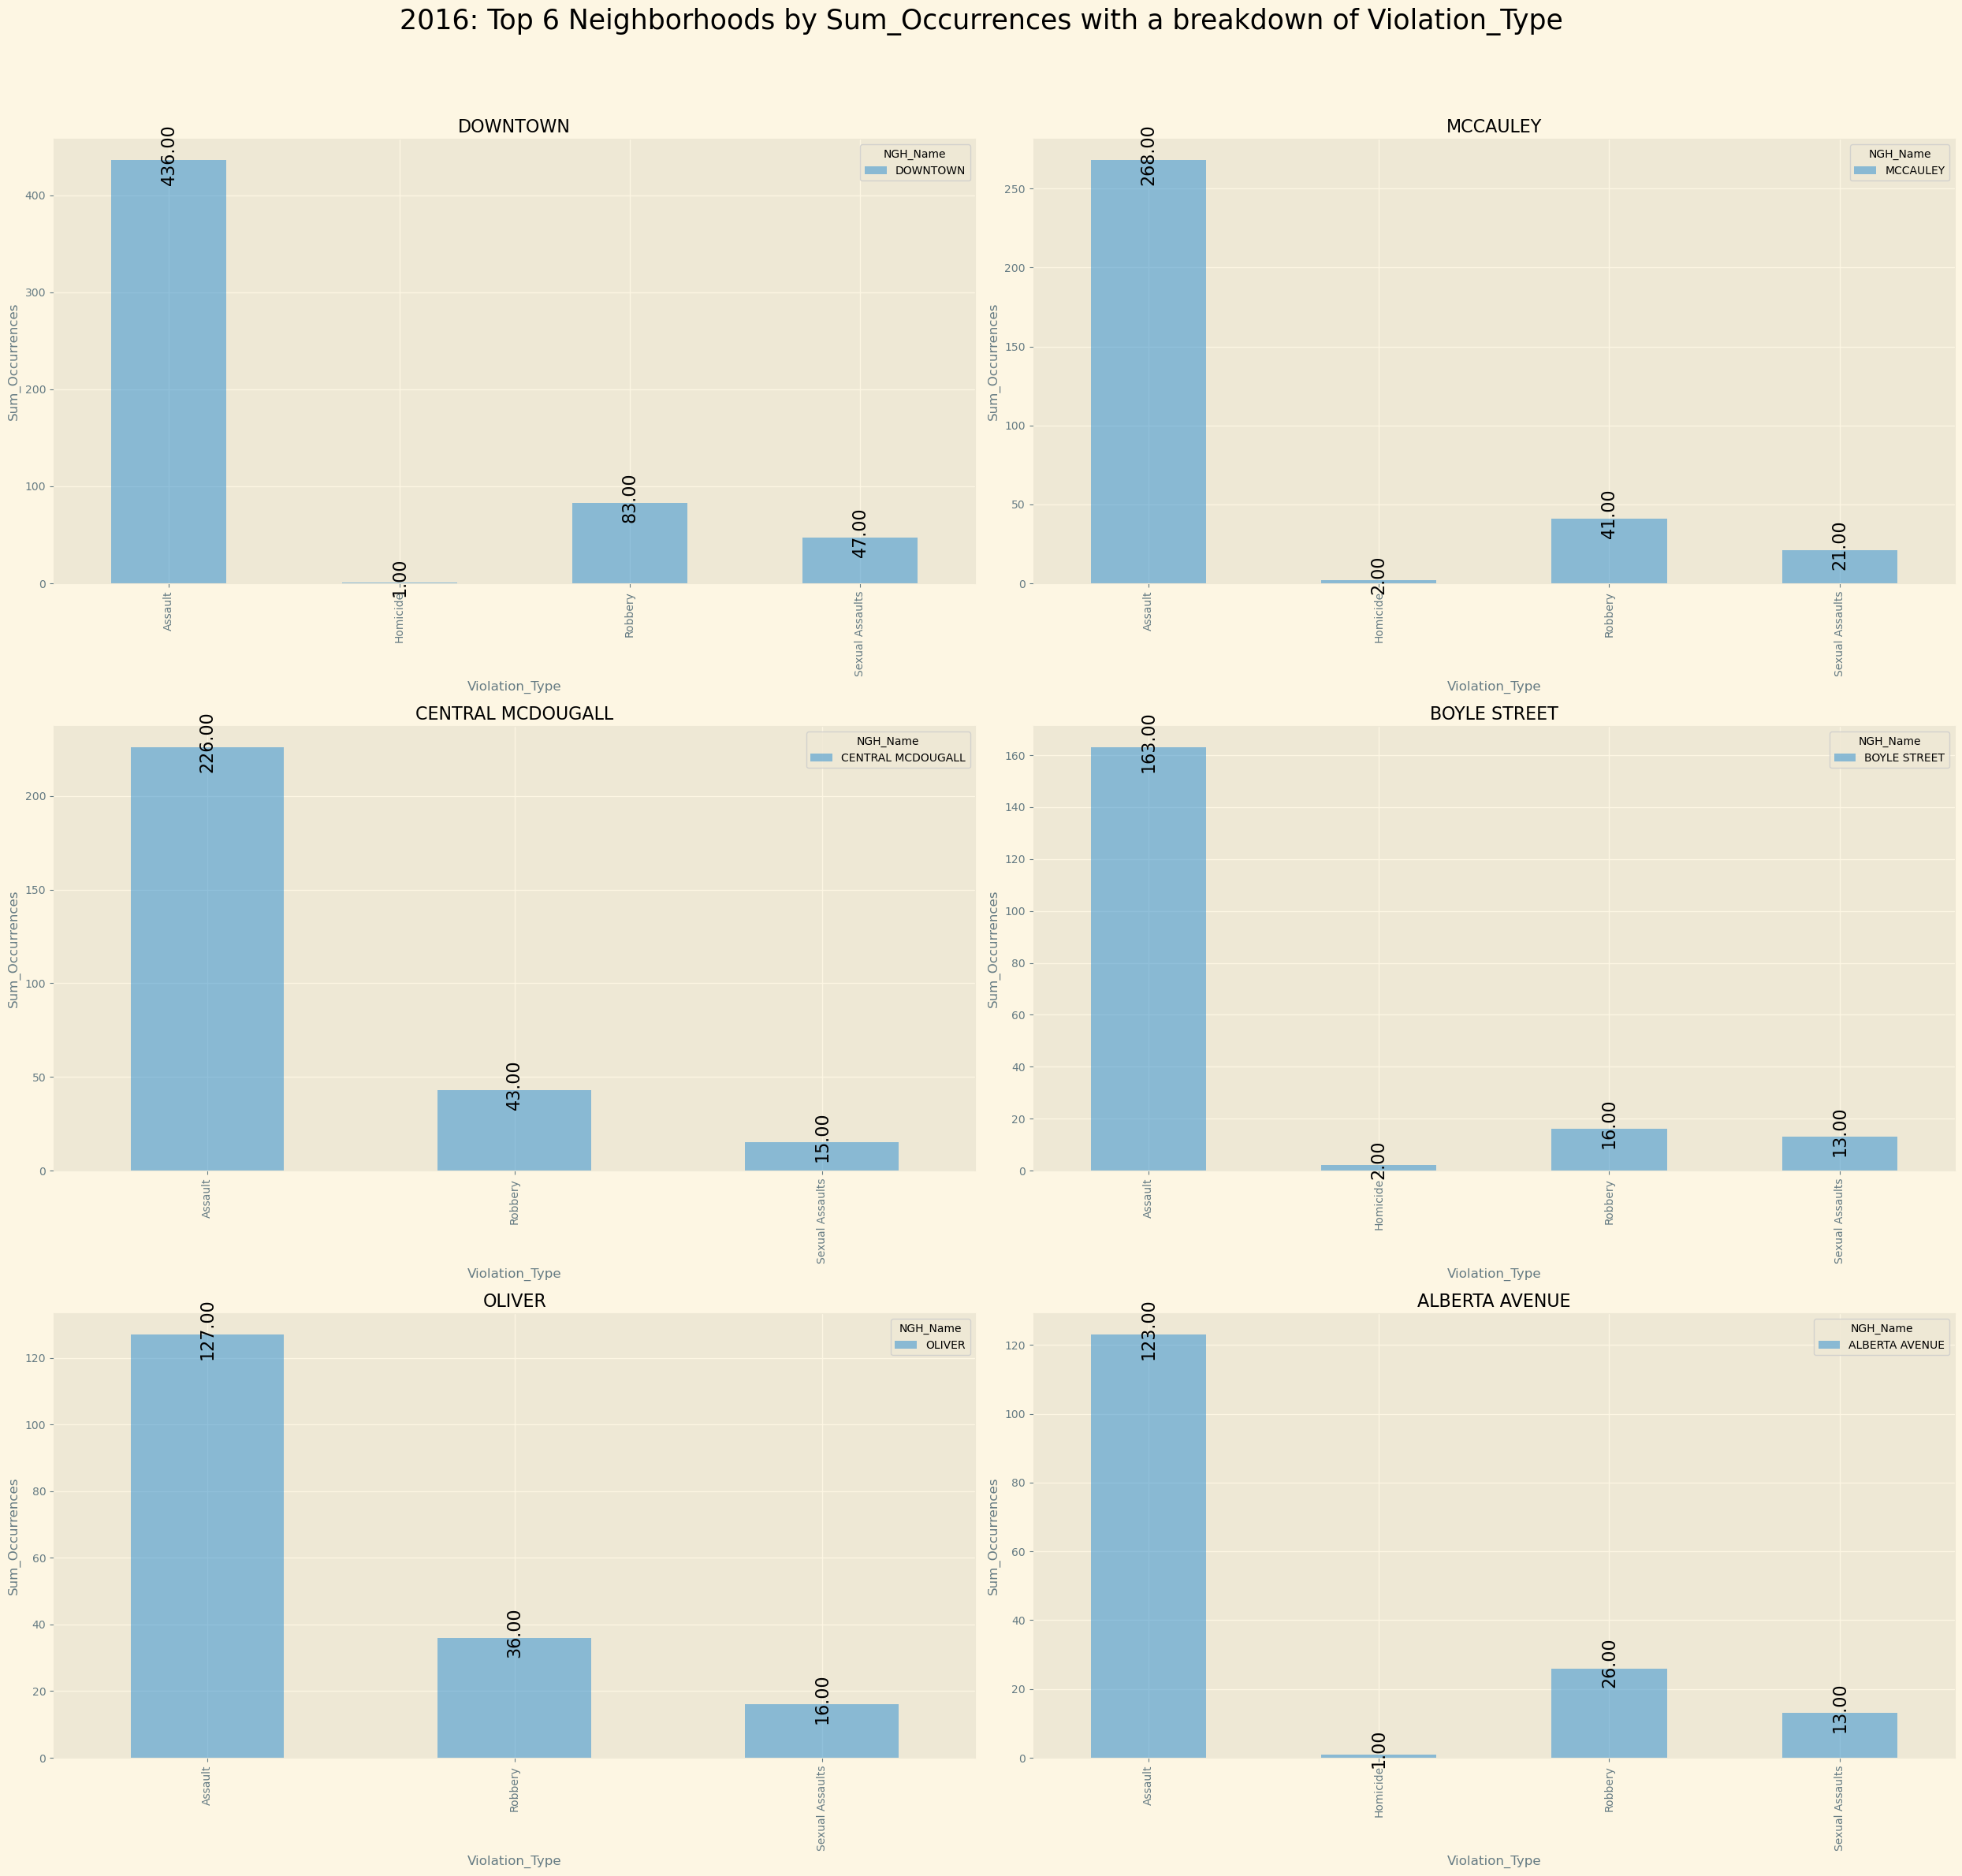

In [7]:
# Define the violation types of interest
#violation_types = ['Assault', 'Homicide', 'Sexual Assaults', 'Robbery']

# Filter the data to the years 2009-2019 and the violation types of interest
#df = df[(df['DT_Year'] >= 2009) & (df['DT_Year'] <= 2019) & (df['Violation_Type'].isin(violation_types))]

# Group the data by Neighborhood and Violation_Type and compute the Sum_Occurrences
grouped = df_2016.groupby(['NGH_Name', 'Violation_Type'])['Sum_Occurrences'].sum().reset_index()

# Sort the groups by Sum_Occurrences and select the top 8 neighborhoods
top_groups = grouped.groupby('NGH_Name')['Sum_Occurrences'].sum().sort_values(ascending=False).head(6)

# Filter the data to only include the top 8 neighborhoods
grouped = grouped[grouped['NGH_Name'].isin(top_groups.index)]

# Create a 4x4 grid of bar plots, where each plot shows the breakdown of Violation_Type for one of the top 8 neighborhoods
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(25, 25))

# Flatten the axes array for easier indexing
axes = axes.flatten()

# Iterate over the top 8 neighborhoods and create a bar plot for each one
for i, group in enumerate(top_groups.index):
    # Filter the data to the current neighborhood
    group_data = grouped[grouped['NGH_Name'] == group]
    
    # Pivot the data to create a table with Violation_Type as rows and Neighborhood as columns
    pivot_table = group_data.pivot(index='Violation_Type', columns='NGH_Name', values='Sum_Occurrences')
    
    # Create a bar plot of the pivot table
    ax = axes[i]
    pivot_table.plot(kind='bar', ax=ax, alpha=0.5)
    ax.set_xlabel('Violation_Type')
    ax.set_ylabel('Sum_Occurrences')
    ax.set_title(group)
    # add annotations
    for p in ax.patches:
        ax.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()),  
                    ha='center', va='center', fontsize=16, color='black', rotation=90, xytext=(0, 5), 
                    textcoords='offset points')

# Hide any unused subplots
for i in range(len(top_groups.index), len(axes)):
    fig.delaxes(axes[i])

# Add a main title to the figure
fig.suptitle('2016: Top 6 Neighborhoods by Sum_Occurrences with a breakdown of Violation_Type', fontsize=25)

# Adjust the layout and spacing of the subplots
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.show()

Distribution of the Violent_type, Assault, Homicide, Robbery, Sexual Assaul, based on ur Top 6 Neighbourhoods.

Let us Pivot our filtered data, just incase.

In [8]:
# Create a pivot table that shows the total number of occurrences for each violation type in each neighborhood
pivoted_df_filtered_2016= pd.pivot_table(df_2016, index=['NGH_Name', 'NGH_Number', 'Latitude', 'Longitude', 'AVG_Temp', 'DT_Year', 'DT_Month'], columns='Violation_Type', values='Sum_Occurrences', aggfunc='sum', fill_value=0)
pivoted_df_filtered_2016 = pivoted_df_filtered_2016.reset_index()
pivoted_df_filtered_2016

Violation_Type,NGH_Name,NGH_Number,Latitude,Longitude,AVG_Temp,DT_Year,DT_Month,Assault,Homicide,Robbery,Sexual Assaults
0,ABBOTTSFIELD,2010,53.574143,-113.388758,-12.038548,2016,December,3,0,1,0
1,ABBOTTSFIELD,2010,53.574143,-113.388758,-9.398871,2016,January,3,0,0,0
2,ABBOTTSFIELD,2010,53.574143,-113.388758,-2.304138,2016,February,3,0,3,0
3,ABBOTTSFIELD,2010,53.574143,-113.388758,0.948667,2016,November,1,0,1,0
4,ABBOTTSFIELD,2010,53.574143,-113.388758,1.883871,2016,March,3,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...
2218,YORK,2720,53.602843,-113.430212,16.359333,2016,June,1,0,2,0
2219,YORK,2720,53.602843,-113.430212,16.532419,2016,August,4,0,1,0
2220,YORK,2720,53.602843,-113.430212,17.764516,2016,July,2,0,0,1
2221,YOUNGSTOWN INDUSTRIAL,4660,53.552476,-113.610588,-2.304138,2016,February,1,0,0,0


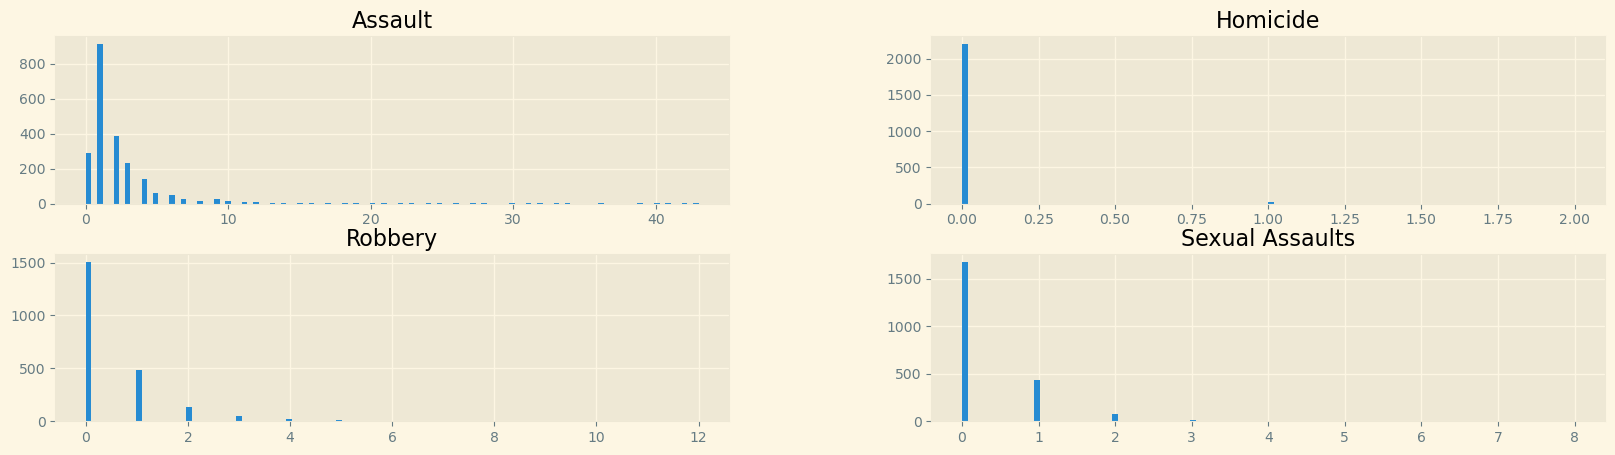

In [9]:
pivoted_df_filtered_2016.iloc[:, 7:].hist(bins=110, figsize=(20, 5))
plt.show()

C:\Users\azimi\AppData\Local\Temp\ipykernel_25648\96391543.py:20: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=violation_df, x='Sum_Occurrences', hue='NGH_Name', fill=True, alpha=0.3, common_norm=False, ax=axes[i])


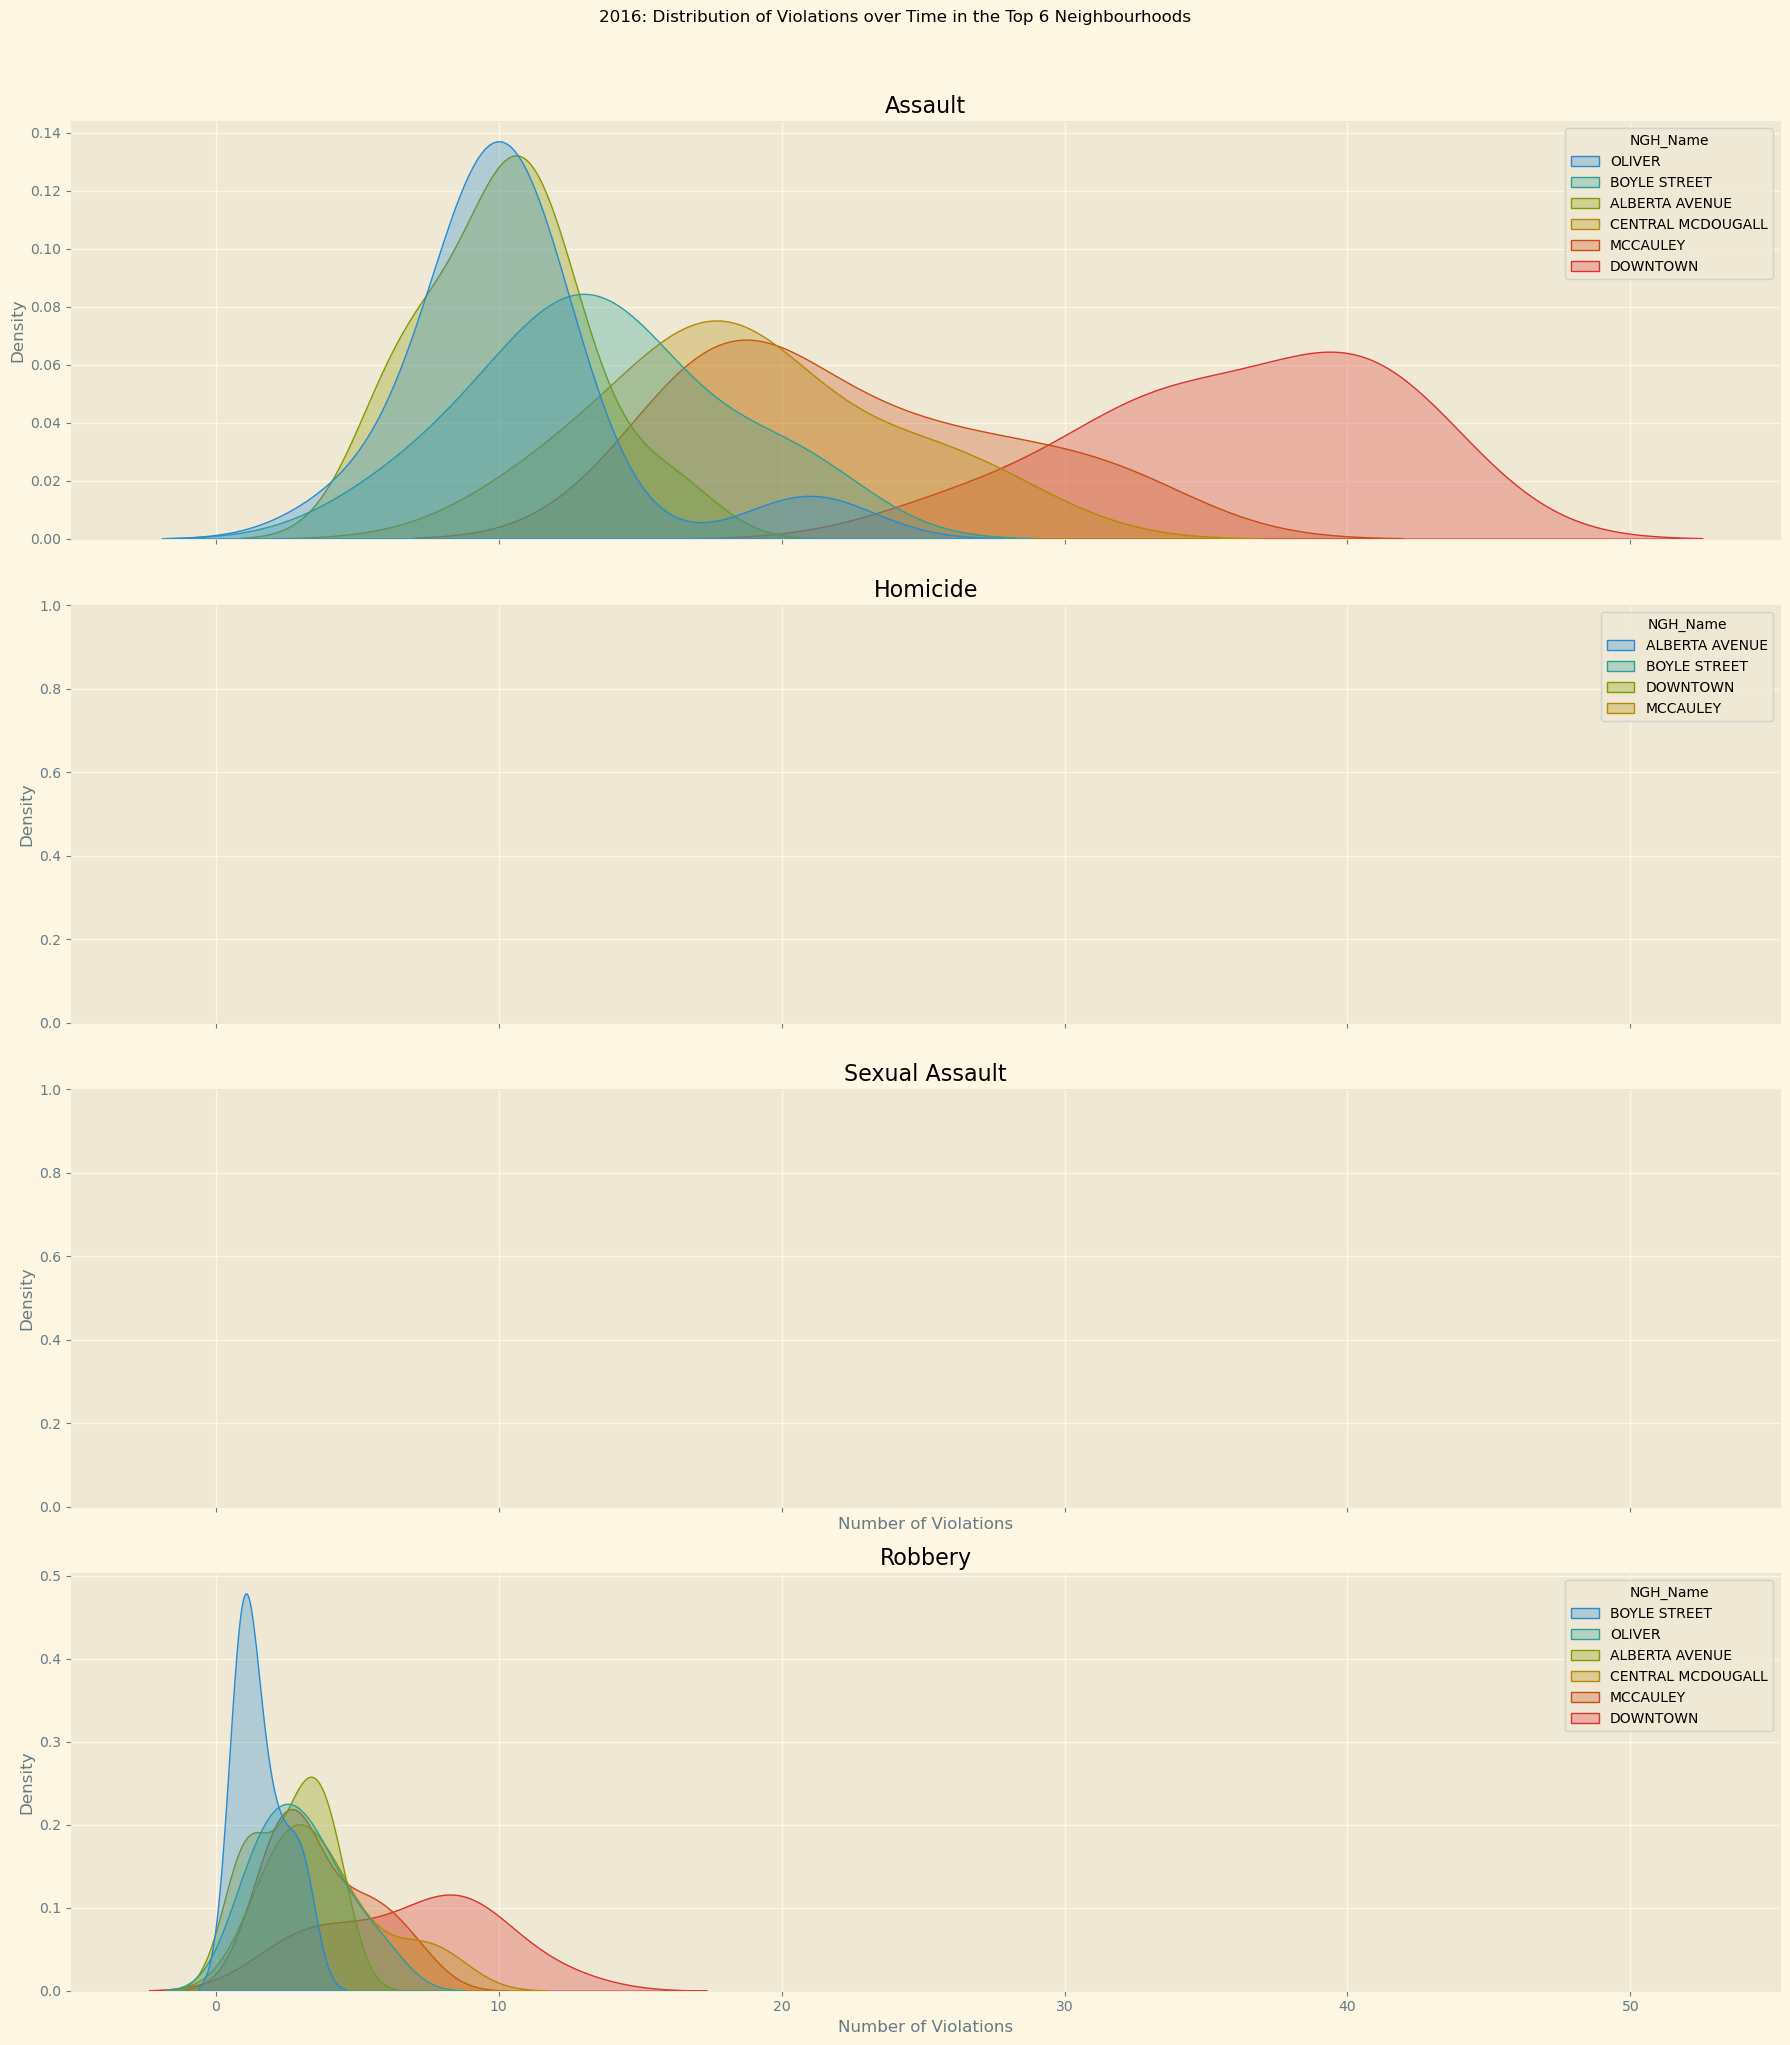

In [10]:
# Filter the data to include only the year 2016
#df_2016 = df.loc[df['DT_Year'] == 2016]

# Define the violation types of interest
violation_types = ['Assault', 'Homicide', 'Sexual Assault', 'Robbery']

# Create a grid of KDE plots for each violation type
fig, axes = plt.subplots(nrows=len(violation_types), ncols=1, figsize=(18, 20), sharex=True)

# Filter the data to include only the top 6 neighbourhoods
top_ngh = ['DOWNTOWN', 'OLIVER', 'MCCAULEY', 'CENTRAL MCDOUGALL', 'BOYLE STREET', 'ALBERTA AVENUE']
ngh_df = df_2016[df_2016['NGH_Name'].isin(top_ngh)]

# Loop through the violation types and create a KDE plot for each one
for i, violation_type in enumerate(violation_types):
    # Filter the data to include only the rows for the current violation type
    violation_df = ngh_df[ngh_df['Violation_Type'] == violation_type]

    # Create a KDE plot of the 'Sum_Occurrences' column for each neighbourhood
    sns.kdeplot(data=violation_df, x='Sum_Occurrences', hue='NGH_Name', fill=True, alpha=0.3, common_norm=False, ax=axes[i])

    # Set the title and axis labels for the plot
    axes[i].set_title(violation_type)
    axes[i].set_xlabel('Number of Violations')
    axes[i].set_ylabel('Density')

# Set the overall title for the plot
plt.suptitle('2016: Distribution of Violations over Time in the Top 6 Neighbourhoods', y=1.02)

# Adjust the spacing between the subplots
plt.tight_layout()

# Show the plot
plt.show()

In [11]:
df_2016.head(2)

,NGH_Name,NGH_Number,Latitude,Longitude,Violation_Type,Sum_Occurrences,DT_Year,DT_Month,AVG_Temp
33016,SAKAW,6670,53.441980,-113.428828,Assault,1,2016,October,2.003065
33017,SATOO,6680,53.446373,-113.458892,Assault,1,2016,October,2.003065


<AxesSubplot:xlabel='Sum_Occurrences', ylabel='Violation_Type'>

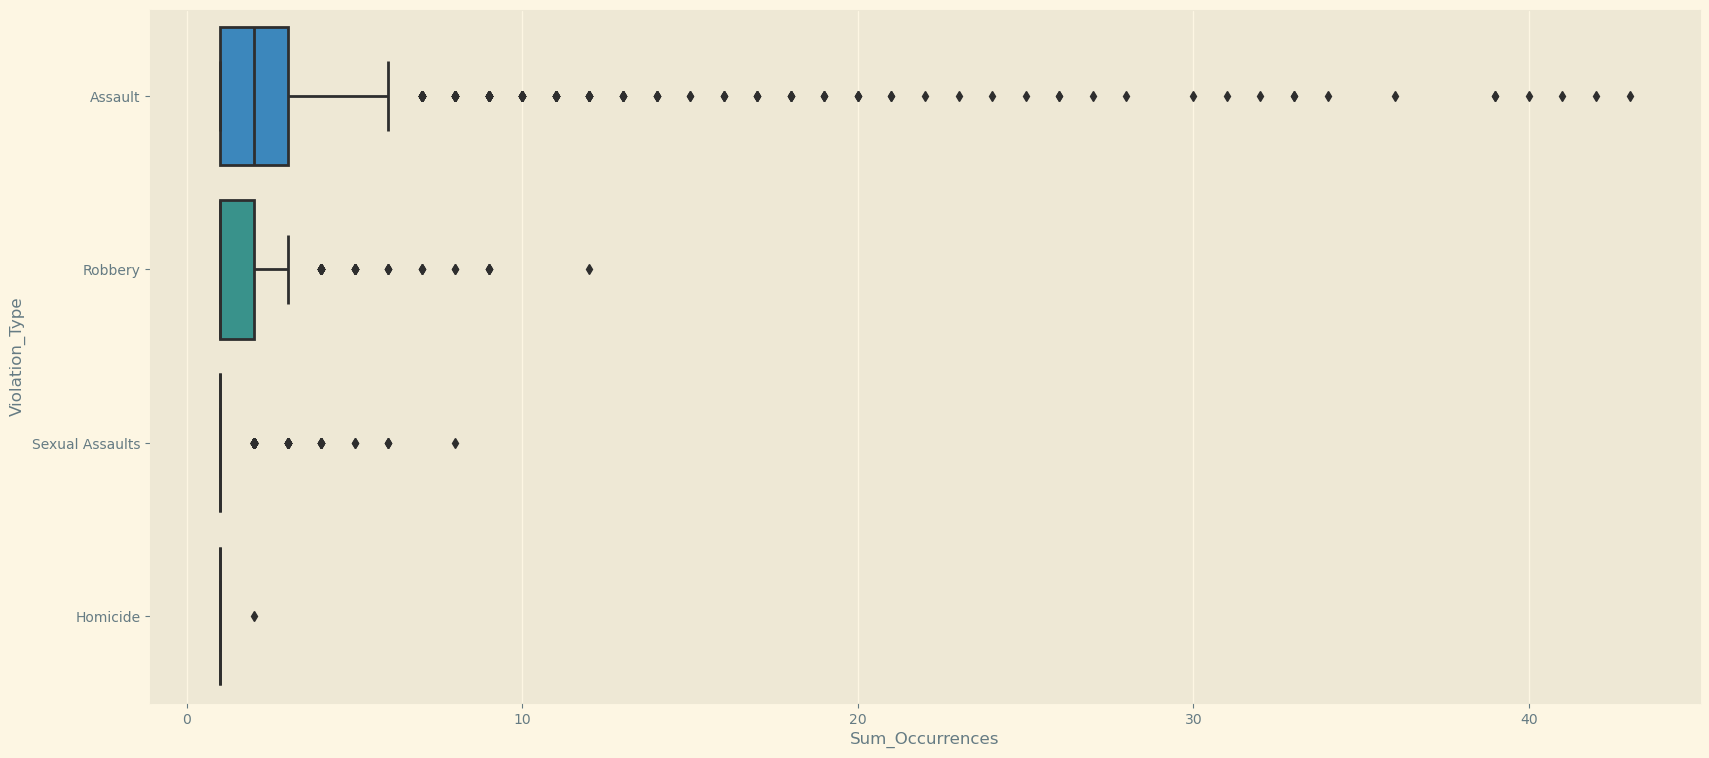

In [12]:
sns.boxplot(data=df_2016, x='Sum_Occurrences', y='Violation_Type')

As we did for 2009-2019, we can view the Mapping the Violent Crimes in Edmonton for 2016 for all neighbourhoods by:
<li>Using the FOLIUM library, then by,
<li>Using Geopandas

In [13]:
# Using FOLIUM library
location_of_most_common_crimes = df_2016[df_2016['Violation_Type'].isin(count_crimes_2016.index)].loc[:, ['Latitude', 'Longitude']].dropna()

my_map=folium.Map(location = [53.4,-113.07], #Initiate map of Edmonton
                  zoom_start = 11,
                  min_zoom = 11
)

HeatMap(data=location_of_most_common_crimes, radius=16).add_to(my_map)

my_map

In [14]:
# Using Geopandas
#https://data.edmonton.ca/Geospatial-Boundaries/2016-Federal-Census-Neighbourhoods-as-of-Official-/3did-mjnj
edmonton_shp=gpd.read_file('geo_export_67517c45-71c1-4f9b-8051-9eaf76457140.shp', geometry='geometry')
edmonton_shp.rename(columns={'name': 'NGH_Name', 'neighbourh': 'NGH_Number'}, inplace=True)
edmonton_shp.drop(['descriptiv', 'date_effec', 'time_effec', 'date_eff_2', 'time_eff_2', 'descriptio'], axis=1, inplace =True)
edmonton_shp.head()


,NGH_Number,NGH_Name,geometry
0,5310.0,PARKALLEN,"POLYGON ((-113.52294 53.50390, -113.52299 53.5..."
1,4400.0,PLACE LARUE,"POLYGON ((-113.63538 53.53748, -113.63986 53.5..."
2,5170.0,EMPIRE PARK,"POLYGON ((-113.49897 53.48824, -113.49765 53.4..."
3,2270.0,EVERGREEN,"POLYGON ((-113.35656 53.62863, -113.35664 53.6..."
4,5520.0,UNIVERSITY OF ALBERTA,"POLYGON ((-113.51500 53.52575, -113.51500 53.5..."


In [15]:
# How are the Crimes distributed among the Neighbourhoods?
Neighborhoods_2016=pd.DataFrame({'Crime_Count':df_2016['NGH_Name'].value_counts().sort_values(ascending=False)})
Neighborhoods_2016.head(6)

,Crime_Count
INGLEWOOD,35
DOWNTOWN,35
MCCAULEY,33
OLIVER,32
BOYLE STREET,31
CENTRAL MCDOUGALL,31


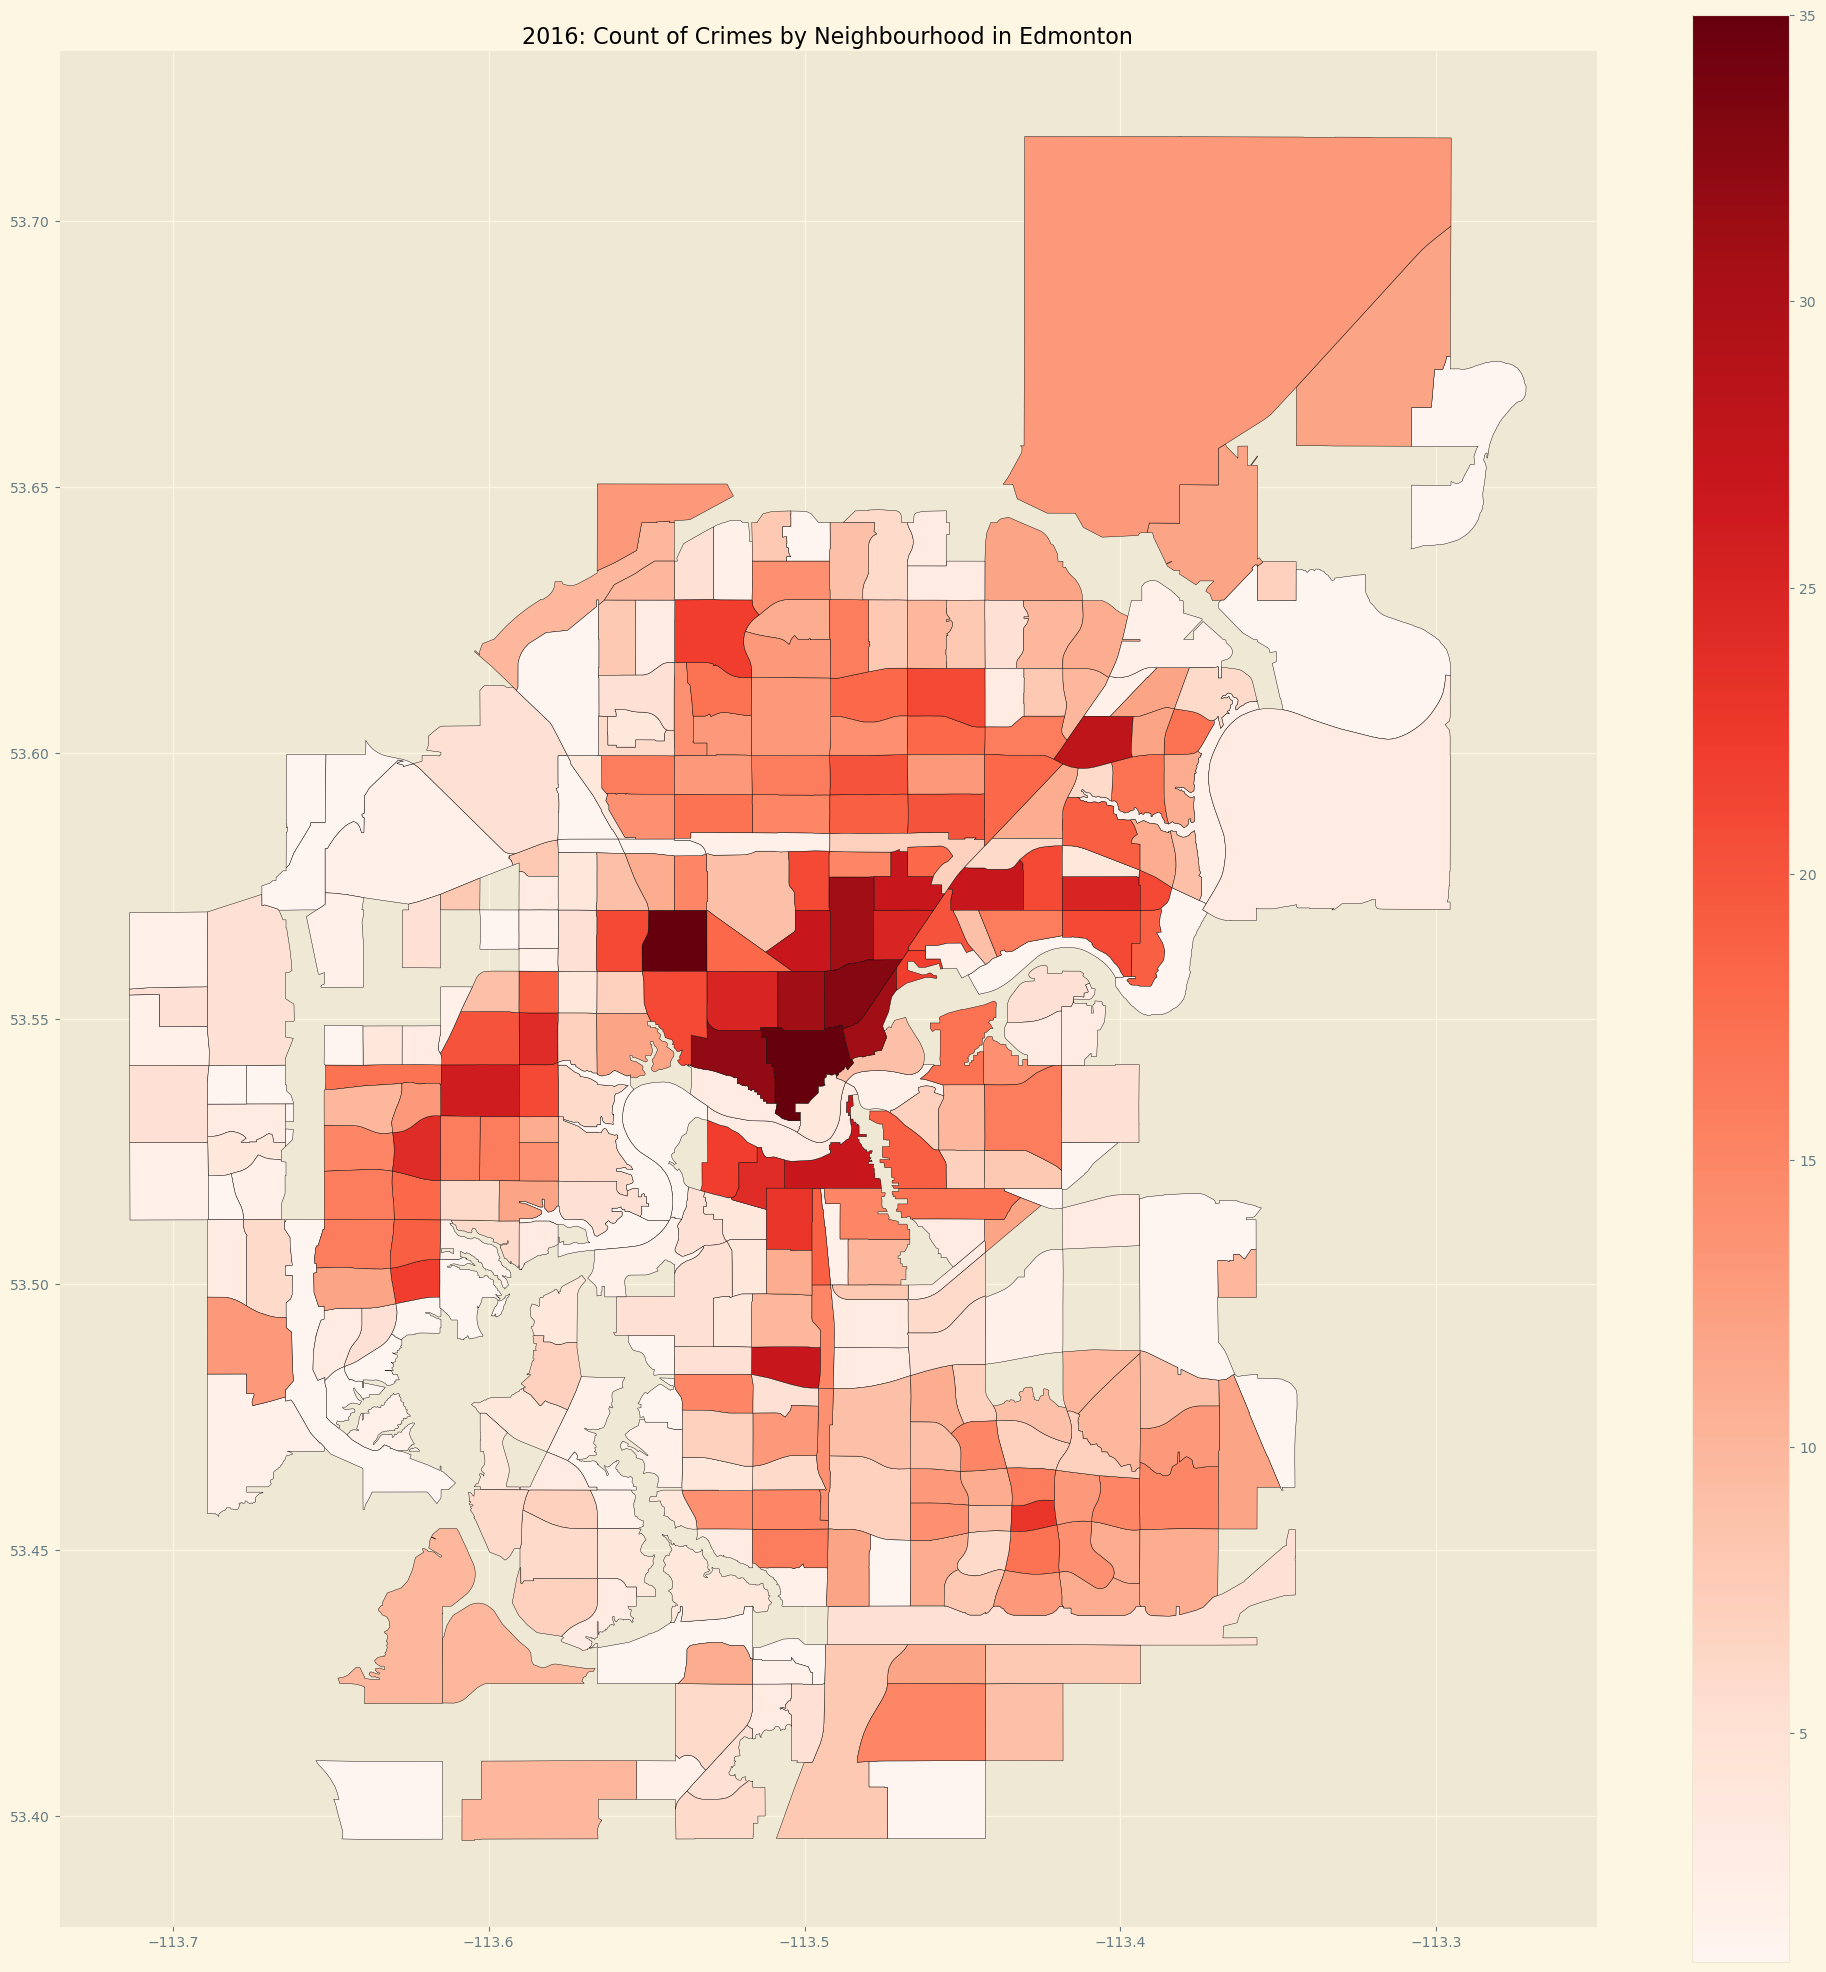

In [16]:
edmonton_shp['Crimes'] = edmonton_shp['NGH_Name'].map(Neighborhoods_2016['Crime_Count']) # use map function to match each district with its corresponding value
# This takes the number of times each individual NGH_Name shows up and creates a column Crimes in edmonton_shp 
ax = edmonton_shp.plot(column = edmonton_shp['Crimes'], cmap = 'Reds', legend = True, edgecolor = 'black', linewidth = 0.3, figsize = (20,20))
#add_label()
plt.title('2016: Count of Crimes by Neighbourhood in Edmonton', fontsize = 16)
plt.tight_layout()